In [1]:
import numpy as np
import torch

torch.manual_seed(0)

import gpytorch
import botorch

from botorch.exceptions.warnings import InputDataWarning, OptimizationWarning

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

import warnings

import pickle

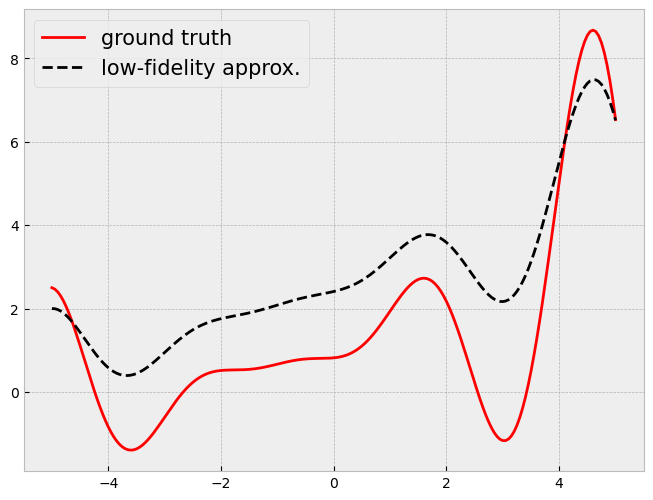

In [2]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


def approx_objective(x):
    return 0.5 * objective(x) + x / 4 + 2


def evaluate_all_functions(x_full):
    y = []
    for x in x_full:
        if torch.isclose(x[-1], torch.ones(1)):
            y.append(objective(x[:-1]))
        else:
            y.append(approx_objective(x[:-1]))

    return torch.tensor(y).unsqueeze(-1)


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)
fidelities = torch.tensor([0.5, 1.0])
bounds_full = torch.cat([bounds, torch.tensor([0.5, 1.0]).unsqueeze(-1)], dim=1)

xs = torch.linspace(lb, ub, 201)

ys = objective(xs)
approx_ys = approx_objective(xs)


plt.plot(xs, ys, label="ground truth", c="r")
plt.plot(xs, approx_ys, "k--", label="low-fidelity approx.")

plt.legend(fontsize=15);

In [3]:
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

from botorch.models.cost import AffineFidelityCostModel
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition.max_value_entropy_search import (
    qMaxValueEntropy,
    qMultiFidelityMaxValueEntropy,
)
from torch.quasirandom import SobolEngine
from botorch.acquisition.utils import project_to_target_fidelity


num_samples = 1000  # sobol samples
# optimize_acqf arguments
num_restarts = 20
raw_samples = 50

cost_model = AffineFidelityCostModel(fixed_cost=0.0)
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

## 9.4 Measuring performance in multi-fidelity optimization

In [4]:
from botorch.acquisition.fixed_feature import FixedFeatureAcquisitionFunction
from botorch.acquisition import PosteriorMean
from botorch.optim.optimize import optimize_acqf, optimize_acqf_mixed


def get_final_recommendation(model):
    post_mean_policy = FixedFeatureAcquisitionFunction(
        acq_function=PosteriorMean(model),
        d=2,
        columns=[1],
        values=[1],
    )

    final_x, _ = optimize_acqf(
        post_mean_policy,
        bounds=bounds,
        q=1,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
    )

    return torch.cat([final_x, torch.ones(1, 1)], dim=1)

In [5]:
budget_limit = 10

In [6]:
class ignore_training_warnings:
    def __enter__(self):
        warnings.filterwarnings("ignore", category=InputDataWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        warnings.filterwarnings("ignore", category=OptimizationWarning)

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.resetwarnings()
        
    
class ignore_optimization_warnings:
    def __enter__(self):
        warnings.filterwarnings("ignore", category=RuntimeWarning)

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.resetwarnings()

In [7]:
strategy = "mes"  # "mfmes" or "mes"
strategy = strategy.upper()

recommendations = []
spent_budget = []

torch.manual_seed(2)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 1)
train_x = torch.cat([train_x, torch.ones_like(train_x) * fidelities[0]], dim=1)

train_y = evaluate_all_functions(train_x)

current_budget = 0

print("current budget:", end=" ")
while current_budget < budget_limit:
    print(f"{current_budget:.2f}", end=" ")

    # train the GP
    with ignore_training_warnings():
        model = SingleTaskMultiFidelityGP(train_x, train_y, data_fidelity=1)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

    # get recommendataion based on the current model
    rec_x = get_final_recommendation(model)
    recommendations.append(evaluate_all_functions(rec_x).item())
    spent_budget.append(current_budget)

    sobol = SobolEngine(1, scramble=True)
    candidate_x = sobol.draw(num_samples)
    candidate_x = bounds[0] + (bounds[1] - bounds[0]) * candidate_x
    candidate_x = torch.cat([candidate_x, torch.ones_like(candidate_x)], dim=1)

    if strategy == "MES":
        policy = FixedFeatureAcquisitionFunction(
            acq_function=qMaxValueEntropy(model, candidate_x, num_fantasies=128),
            d=2,
            columns=[1],
            values=[1],
        )
        
        with ignore_optimization_warnings():
            next_x, acq_val = optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=num_restarts,
                raw_samples=raw_samples,
            )

        next_x = torch.cat([next_x, torch.ones_like(next_x)], dim=1)

    if strategy == "MFMES":
        policy = qMultiFidelityMaxValueEntropy(
            model,
            candidate_x,
            num_fantasies=128,
            cost_aware_utility=cost_aware_utility,
            project=project_to_target_fidelity,
        )
        
        with ignore_optimization_warnings():
            next_x, acq_val = optimize_acqf_mixed(
                policy,
                bounds=bounds_full,
                fixed_features_list=[{1: cost.item()} for cost in fidelities],
                q=1,
                num_restarts=num_restarts,
                raw_samples=raw_samples,
            )

    next_y = evaluate_all_functions(next_x)
    current_budget += cost_model(next_x).item()

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

current budget: 0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 

In [8]:
with open(f"./forrester_one_run/{strategy}.pkl", "wb") as f:
    pickle.dump([recommendations, spent_budget], f)

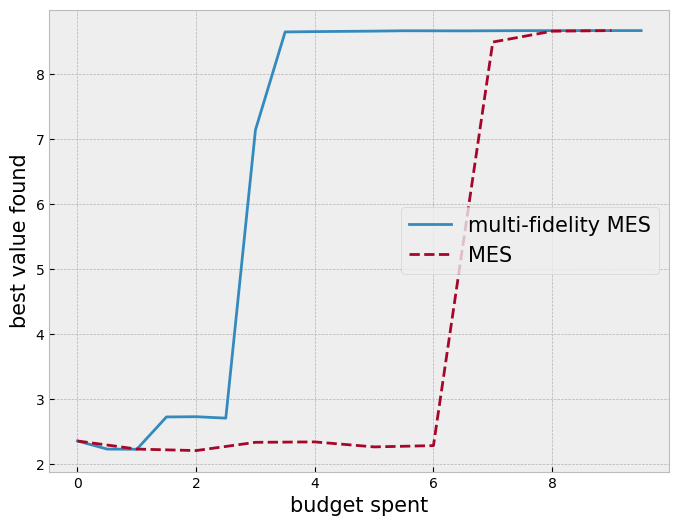

In [9]:
with open("./forrester_one_run/MFMES.pkl", "rb") as f:
    incumbents, spent_budget = pickle.load(f)
    
plt.plot(spent_budget, incumbents, "C0-", label="multi-fidelity MES")

with open("./forrester_one_run/MES.pkl", "rb") as f:
    incumbents, spent_budget = pickle.load(f)
    
plt.plot(spent_budget, incumbents, "C1--", label="MES")

plt.xlabel("budget spent", fontsize=15)
plt.ylabel("best value found", fontsize=15)

plt.legend(fontsize=15);